# Рекомендательная система тарифов

**Описание исследования**  

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже была сделана ранее.
Необходимо построить модель с максимально большим значением accuracy, но не менее 0.75. Проверить accuracy на тестовой выборке.

**Цель исследования**
- Применить различные модели машинного обучения к представленным данным
- Выбрать наиболее эффективную модель и проверить ее качество на тестовой выборке
- Проверить модель на вменяемость

**Ход исследования**
- Обзор данных
- Предобработка данных (если потребуется)
- Разбиение на тренировочную, валидационную и тестовую выборки
- Обучение различных моделей машинного обучения
- Проверка на тестовой выборке
- Общий вывод

## Обзор данных

### Импортируем необходимые библиотеки и считыем данных csv-файла

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint


from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

In [2]:
try:
    df = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_5_intro_to_machine_learning\data\users_behavior.csv"
    )
except:
    df = pd.read_csv(r"/datasets/users_behavior.csv")

In [3]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
df.shape

(3214, 5)

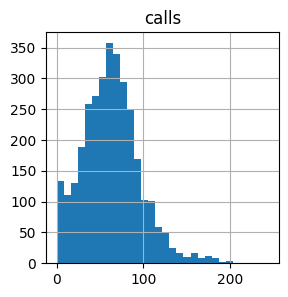

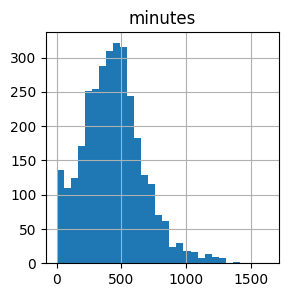

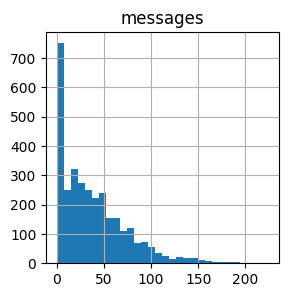

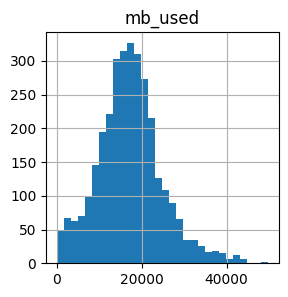

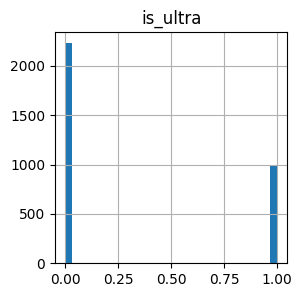

In [7]:
for column in df:
    try:
        df.hist(column=column, bins=30, figsize=(3, 3))
    except:
        print(f"Для столбца {column} построить гистограмму не вышло.")

In [8]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Между столбцами `calls` и `minutes` видна сильная корреляция, значит, один из них стоит убрать для корректного обучения моделей. Уберем calls, поскольку число звонков слабо отражает потребности клиента - звонков может быть много, но все буквально по 10 секунд, из-за чего месячный лимит не используется, и наоборот, звонков немного, но все они длинные, из-за чего человек выходит за месячный лимит и платит лишние деньги за доп. минуты (чем не аргумент для привлечения клиента к новому предложению?) 

In [9]:
df = df.drop(columns="calls")

In [10]:
df.duplicated().sum()

0

Итак, нам предстоит решить задачу бинарной классификации - предугадать, какой из двух тарифов подключен у клиента. Для этого будет производиться обучение моделей на основе следующих данных: 
- Минуты, потраченные во время звонков
- Число отправленных СМС
- Размер использованного трафика  

Изначально в датасете был также представлен столбец `calls`, но был удален из-за высокой корреляции с `minutes`.  

Также заметен дисбаланс между классами, где пользователей с тарифом Смарт в два с небольшим раза больше, чем с тарифом Ультра. 

## Тренировочная, валидационная и тестовая выборки

Разделим датафрейм на выборки в соотношении 3:1:1

In [11]:
features = df.drop(columns="is_ultra")
target = df["is_ultra"]

In [12]:
features_temp, features_test, target_temp, target_test = train_test_split(
    features, target, test_size=0.2, random_state=821
)

In [13]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_temp, target_temp, test_size=0.25, random_state=821
)

In [14]:
print(features_train.shape, features_valid.shape, features_test.shape)

(1928, 3) (643, 3) (643, 3)


## Применение различных моделей

Для решений задачи классификации будем использовать набор классификаторов, представленных в библиотеке sclearn: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, KNeighborsClassifier, AdaBoostClassifier, Naive Bayes, SVC, MLPClassifier

### Подбор гипер-параметров с помощью GridSearchCV

Для подбора гипер-параметров с помощью GridSearchCV создадим функцию, выполняющую данную задачу:

In [15]:
def classifiers_scoring_grid_search(
    features_train,
    target_train,
    features_valid,
    target_valid,
    features_test,
    target_test,
):
    # Decision Tree

    tree_parameters = {
        "random_state": [821],
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "min_samples_split": [2, 4, 8, 16, 32],
        "min_samples_leaf": [1, 3, 9, 18],
        "class_weight": ["balanced", None],
    }

    grid_search_tree = GridSearchCV(
        estimator=DecisionTreeClassifier(), param_grid=tree_parameters, cv=5
    )
    grid_search_tree.fit(features_train, target_train)

    model_tree = grid_search_tree.best_estimator_
    model_tree.fit(features_train, target_train)
    valid_score_tree = model_tree.score(features_valid, target_valid)
    test_score_tree = model_tree.score(features_test, target_test)
    print(
        f"Результат лучшей модели DecisionTree на валидационной выборке: {valid_score_tree}.\n\
Гипер-параметры: {grid_search_tree.best_params_}\n"
    )

    # Random Forest

    forest_parameters = {
        "n_estimators": [10, 25, 50, 75, 100, 150, 250],
        "random_state": [821],
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "class_weight": ["balanced", "balanced_subsample", None],
    }

    grid_search_forest = GridSearchCV(
        estimator=RandomForestClassifier(), param_grid=forest_parameters, cv=5
    )
    grid_search_forest.fit(features_train, target_train)

    model_forest = grid_search_forest.best_estimator_
    model_forest.fit(features_train, target_train)
    valid_score_forest = model_forest.score(features_valid, target_valid)
    test_score_forest = model_forest.score(features_test, target_test)
    print(
        f"Результат лучшей модели RandomForest на валидационной выборке: {valid_score_forest}.\n\
Гипер-параметры: {grid_search_forest.best_params_}\n"
    )

    # Logistic Regression

    logistic_parameters = {
        "solver": ["liblinear"],
        "max_iter": [100, 500, 1000, 2000],
        "random_state": [821],
        "tol": [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
        "C": [0.01, 0.1, 1.0, 10, 100],
    }

    grid_search_logistic = GridSearchCV(
        estimator=LogisticRegression(), param_grid=logistic_parameters, cv=5
    )
    grid_search_logistic.fit(features_train, target_train)

    model_logistic = grid_search_logistic.best_estimator_
    model_logistic.fit(features_train, target_train)
    valid_score_logistic = model_logistic.score(features_valid, target_valid)
    test_score_logistic = model_logistic.score(features_test, target_test)
    print(
        f"Результат лучшей модели LogisticRegression на валидационной выборке: {valid_score_logistic}.\n\
Гипер-параметры: {grid_search_logistic.best_params_}\n"
    )

    # Nearest Neighbors

    neighbors_parameters = {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "algorithm": ["ball_tree", "kd_tree", "brute"],
        "leaf_size": [15, 30, 45],
    }

    grid_search_neighbors = GridSearchCV(
        estimator=KNeighborsClassifier(), param_grid=neighbors_parameters, cv=5
    )
    grid_search_neighbors.fit(features_train, target_train)

    model_neighbors = grid_search_neighbors.best_estimator_
    model_neighbors.fit(features_train, target_train)
    valid_score_neighbors = model_neighbors.score(features_valid, target_valid)
    test_score_neighbors = model_neighbors.score(features_test, target_test)
    print(
        f"Результат лучшей модели NearestNeighbors на валидационной выборке: {valid_score_neighbors}.\n\
Гипер-параметры: {grid_search_neighbors.best_params_}\n"
    )

    # SVC

    svc_parameters = {
        "C": [0.01, 0.1, 1.0, 10, 100],
        "tol": [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
        "random_state": [821],
        "class_weight": ["balanced", None],
    }

    grid_search_svc = GridSearchCV(estimator=SVC(), param_grid=svc_parameters, cv=5)
    grid_search_svc.fit(features_train, target_train)

    model_svc = grid_search_svc.best_estimator_
    model_svc.fit(features_train, target_train)
    valid_score_svc = model_svc.score(features_valid, target_valid)
    test_score_svc = model_svc.score(features_test, target_test)
    print(
        f"Результат лучшей модели SVC на валидационной выборке: {valid_score_svc}.\n\
Гипер-параметры: {grid_search_svc.best_params_}\n"
    )

    # MyLittlePony

    mlp_parameters = {
        "alpha": [0.001, 0.01, 0.1, 1.0, 10, 100],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
        "random_state": [821],
        "max_iter": [100, 200, 400, 1000],
    }

    grid_search_mlp = GridSearchCV(
        estimator=MLPClassifier(), param_grid=mlp_parameters, cv=5
    )
    grid_search_mlp.fit(features_train, target_train)

    model_mlp = grid_search_mlp.best_estimator_
    model_mlp.fit(features_train, target_train)
    valid_score_mlp = model_mlp.score(features_valid, target_valid)
    test_score_mlp = model_mlp.score(features_test, target_test)
    print(
        f"Результат лучшей модели MLP на валидационной выборке: {valid_score_mlp}.\n\
Гипер-параметры: {grid_search_mlp.best_params_}\n"
    )

    # AdaBoost

    ada_parameters = {
        "n_estimators": [10, 25, 50, 75, 100, 150, 250],
        "random_state": [821],
        "learning_rate": [0.01, 0.1, 1, 10],
    }

    grid_search_ada = GridSearchCV(
        estimator=AdaBoostClassifier(), param_grid=ada_parameters, cv=5
    )
    grid_search_ada.fit(features_train, target_train)

    model_ada = grid_search_ada.best_estimator_
    model_ada.fit(features_train, target_train)
    valid_score_ada = model_ada.score(features_valid, target_valid)
    test_score_ada = model_ada.score(features_test, target_test)
    print(
        f"Результат лучшей модели AdaBoost на валидационной выборке: {valid_score_ada}.\n\
Гипер-параметры: {grid_search_ada.best_params_}\n"
    )

    # Naive Bayes

    gnb_parameters = {
        "var_smoothing": [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
    }

    grid_search_gnb = GridSearchCV(
        estimator=GaussianNB(), param_grid=gnb_parameters, cv=5
    )
    grid_search_gnb.fit(features_train, target_train)

    model_gnb = grid_search_gnb.best_estimator_
    model_gnb.fit(features_train, target_train)
    valid_score_gnb = model_gnb.score(features_valid, target_valid)
    test_score_gnb = model_gnb.score(features_test, target_test)
    print(
        f"Результат лучшей модели GaussianNB на валидационной выборке: {valid_score_gnb}.\n\
Гипер-параметры: {grid_search_gnb.best_params_}\n"
    )

    # QDA

    qda_parameters = {
        "tol": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
        "reg_param": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    }

    grid_search_qda = GridSearchCV(
        estimator=QuadraticDiscriminantAnalysis(), param_grid=qda_parameters, cv=5
    )
    grid_search_qda.fit(features_train, target_train)

    model_qda = grid_search_qda.best_estimator_
    model_qda.fit(features_train, target_train)
    valid_score_qda = model_qda.score(features_valid, target_valid)
    test_score_qda = model_qda.score(features_test, target_test)
    print(
        f"Результат лучшей модели QDA на валидационной выборке: {valid_score_qda}.\n\
Гипер-параметры: {grid_search_qda.best_params_}\n"
    )

    # ScoringTable

    global estimators_list

    estimators_list = [
        "Decision Tree",
        "Random Forest",
        "Logistic Regression",
        "Nearest Neighbors",
        "SVC",
        "MLP",
        "AdaBoost",
        "Naive Bayes",
        "QDA",
    ]
    valid_score_list = [
        valid_score_tree,
        valid_score_forest,
        valid_score_logistic,
        valid_score_neighbors,
        valid_score_svc,
        valid_score_mlp,
        valid_score_ada,
        valid_score_gnb,
        valid_score_qda,
    ]
    # test_score_list = [test_score_tree, test_score_forest, test_score_logistic, test_score_neighbors, test_score_svc,\
    # test_score_mlp,test_score_ada, test_score_gnb, test_score_qda]

    global grid_estimators_score

    grid_estimators_score = (
        pd.DataFrame(data={"grid_valid_score": valid_score_list}, index=estimators_list)
        .sort_values(by="grid_valid_score", ascending=False)
        .style.background_gradient("coolwarm")
    )

    global selected_grid_models

    selected_grid_models = [
        model_tree,
        model_forest,
        model_logistic,
        model_neighbors,
        model_svc,
        model_mlp,
        model_ada,
        model_gnb,
        model_qda,
    ]

In [16]:
classifiers_scoring_grid_search(
    features_train,
    target_train,
    features_valid,
    target_valid,
    features_test,
    target_test,
)
grid_estimators_score

Результат лучшей модели DecisionTree на валидационной выборке: 0.7807153965785381.
Гипер-параметры: {'class_weight': None, 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 16, 'random_state': 821}

Результат лучшей модели RandomForest на валидационной выборке: 0.7962674961119751.
Гипер-параметры: {'class_weight': None, 'max_depth': 10, 'n_estimators': 100, 'random_state': 821}

Результат лучшей модели LogisticRegression на валидационной выборке: 0.7558320373250389.
Гипер-параметры: {'C': 1.0, 'max_iter': 100, 'random_state': 821, 'solver': 'liblinear', 'tol': 1e-05}

Результат лучшей модели NearestNeighbors на валидационной выборке: 0.7511664074650077.
Гипер-параметры: {'algorithm': 'ball_tree', 'leaf_size': 15, 'n_neighbors': 7, 'weights': 'uniform'}

Результат лучшей модели SVC на валидационной выборке: 0.7542768273716952.
Гипер-параметры: {'C': 100, 'class_weight': None, 'random_state': 821, 'tol': 0.1}

Результат лучшей модели MLP на валидационной выборке: 0.715396578538

,grid_valid_score
AdaBoost,0.797823
Random Forest,0.796267
QDA,0.782271
Decision Tree,0.780715
Naive Bayes,0.768274
Logistic Regression,0.755832
SVC,0.754277
Nearest Neighbors,0.751166
MLP,0.715397


8 из 9 классификаторов достигли точности 75%, однако ни один из них не дошел хотя бы до 85%. 

### Подбор гипер-параметров с помощью RandomizedSearchCV

Аналогично GridSearchCV, создадим функцию подбора.  
n_iter управляет числом итераций подбора гипер-параметров. Ниже создается список из двух значений, первое - число итераций, используемое в "медленных" моделях (Forest, Ada, MLP), второе - число итераций, используемое в "быстрых" моделях. Увеличение первого числа значительно замедляет выполнение функции. 

In [17]:
n_iter = [15, 50]

In [18]:
def classifiers_scoring_randomized_search(
    randomized_features_train,
    randomized_target_train,
    randomized_features_valid,
    randomized_target_valid,
    randomized_features_test,
    randomized_target_test,
    n_iter,
):
    # Decision Tree Classifier

    randomized_tree_parameters = {
        "random_state": [821],
        "max_depth": randint(1, 15),
        "min_samples_split": randint(2, 50),
        "min_samples_leaf": randint(1, 30),
        "class_weight": ["balanced", None],
    }

    randomized_search_tree = RandomizedSearchCV(
        estimator=DecisionTreeClassifier(),
        param_distributions=randomized_tree_parameters,
        cv=5,
        n_iter=max(n_iter),
    )
    randomized_search_tree.fit(randomized_features_train, randomized_target_train)

    randomized_model_tree = randomized_search_tree.best_estimator_
    randomized_model_tree.fit(features_train, target_train)
    randomized_valid_score_tree = randomized_model_tree.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_tree = randomized_model_tree.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели DecisionTree на валидационной выборке: {randomized_valid_score_tree}.\n\
Гипер-параметры: {randomized_search_tree.best_params_}\n"
    )

    # Random Forest Classifier

    randomized_forest_parameters = {
        "n_estimators": randint(4, 400),
        "random_state": [821],
        "max_depth": randint(1, 20),
        "class_weight": ["balanced", "balanced_subsample", None],
    }

    randomized_search_forest = RandomizedSearchCV(
        estimator=RandomForestClassifier(),
        param_distributions=randomized_forest_parameters,
        cv=5,
        n_iter=min(n_iter),
    )
    randomized_search_forest.fit(randomized_features_train, randomized_target_train)

    randomized_model_forest = randomized_search_forest.best_estimator_
    randomized_model_forest.fit(randomized_features_train, randomized_target_train)
    randomized_valid_score_forest = randomized_model_forest.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_forest = randomized_model_forest.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели RandomForest на валидационной выборке: {randomized_valid_score_forest}.\n\
Гипер-параметры: {randomized_search_forest.best_params_}\n"
    )

    # Logistic Regression

    degrees_logistic = np.random.randint(-10, -2, max(n_iter))
    tols_logistic = []
    for degree in degrees_logistic:
        tols_logistic.append(10.0**degree)
    tols_logistic

    randomized_logistic_parameters = {
        "solver": ["liblinear"],
        "max_iter": randint(100, 2000),
        "random_state": [821],
        "tol": tols_logistic,
        "C": uniform(0.01, 100),
    }

    randomized_search_logistic = RandomizedSearchCV(
        estimator=LogisticRegression(),
        param_distributions=randomized_logistic_parameters,
        cv=5,
        n_iter=max(n_iter),
    )
    randomized_search_logistic.fit(randomized_features_train, randomized_target_train)

    randomized_model_logistic = randomized_search_logistic.best_estimator_
    randomized_model_logistic.fit(randomized_features_train, randomized_target_train)
    randomized_valid_score_logistic = randomized_model_logistic.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_logistic = randomized_model_logistic.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели LogisticRegression на валидационной выборке: {randomized_valid_score_logistic}.\n\
Гипер-параметры: {randomized_search_logistic.best_params_}\n"
    )

    # Nearest Neighbors Classifier

    randomized_neighbors_parameters = {
        "n_neighbors": randint(2, 10),
        "weights": ["uniform", "distance"],
        "algorithm": ["ball_tree", "kd_tree", "brute"],
        "leaf_size": randint(10, 50),
    }

    randomized_search_neighbors = RandomizedSearchCV(
        estimator=KNeighborsClassifier(),
        param_distributions=randomized_neighbors_parameters,
        cv=5,
        n_iter=max(n_iter),
    )
    randomized_search_neighbors.fit(randomized_features_train, randomized_target_train)

    randomized_model_neighbors = randomized_search_neighbors.best_estimator_
    randomized_model_neighbors.fit(randomized_features_train, randomized_target_train)
    randomized_valid_score_neighbors = randomized_model_neighbors.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_neighbors = randomized_model_neighbors.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели NearestNeighbors на валидационной выборке: {randomized_valid_score_neighbors}.\n\
Гипер-параметры: {randomized_search_neighbors.best_params_}\n"
    )

    # SVC

    degrees_svc = np.random.randint(-10, 1, max(n_iter))
    tols_svc = []
    for degree in degrees_svc:
        tols_svc.append(10.0**degree)
    tols_svc

    randomized_svc_parameters = {
        "C": uniform(0.01, 100),
        "tol": tols_svc,
        "random_state": [821],
        "class_weight": ["balanced", None],
    }

    randomized_search_svc = RandomizedSearchCV(
        estimator=SVC(),
        param_distributions=randomized_svc_parameters,
        cv=5,
        n_iter=max(n_iter),
    )
    randomized_search_svc.fit(randomized_features_train, randomized_target_train)

    randomized_model_svc = randomized_search_svc.best_estimator_
    randomized_model_svc.fit(randomized_features_train, randomized_target_train)
    randomized_valid_score_svc = randomized_model_svc.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_svc = randomized_model_svc.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели SVC на валидационной выборке: {randomized_valid_score_svc}.\n\
Гипер-параметры: {randomized_search_svc.best_params_}\n"
    )

    # MyLittlePony Classifier

    degrees_mlp = np.random.randint(-8, -2, min(n_iter))
    tols_mlp = []
    for degree in degrees_mlp:
        tols_mlp.append(10.0**degree)
    tols_mlp

    randomized_mlp_parameters = {
        "alpha": uniform(0.001, 100),
        "tol": tols_mlp,
        "random_state": [821],
        "max_iter": randint(100, 1500),
    }

    randomized_search_mlp = RandomizedSearchCV(
        estimator=MLPClassifier(),
        param_distributions=randomized_mlp_parameters,
        cv=5,
        n_iter=min(n_iter),
    )
    randomized_search_mlp.fit(randomized_features_train, randomized_target_train)

    randomized_model_mlp = randomized_search_mlp.best_estimator_
    randomized_model_mlp.fit(randomized_features_train, randomized_target_train)
    randomized_valid_score_mlp = randomized_model_mlp.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_mlp = randomized_model_mlp.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели MLP на валидационной выборке: {randomized_valid_score_mlp}.\n\
Гипер-параметры: {randomized_search_mlp.best_params_}\n"
    )

    # AdaBoost

    randomized_ada_parameters = {
        "n_estimators": randint(4, 400),
        "random_state": [821],
        "learning_rate": uniform(0.01, 10),
    }

    randomized_search_ada = RandomizedSearchCV(
        estimator=AdaBoostClassifier(),
        param_distributions=randomized_ada_parameters,
        cv=5,
        n_iter=min(n_iter),
    )
    randomized_search_ada.fit(randomized_features_train, randomized_target_train)

    randomized_model_ada = randomized_search_ada.best_estimator_
    randomized_model_ada.fit(randomized_features_train, randomized_target_train)
    randomized_valid_score_ada = randomized_model_ada.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_ada = randomized_model_ada.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели AdaBoost на валидационной выборке: {randomized_valid_score_ada}.\n\
Гипер-параметры: {randomized_search_ada.best_params_}\n"
    )

    # Naive Bayes

    degrees_gnb = np.random.randint(-14, -7, max(n_iter))
    vs_gnb = []
    for degree in degrees_gnb:
        vs_gnb.append(10.0**degree)
    vs_gnb

    randomized_gnb_parameters = {"var_smoothing": vs_gnb}

    randomized_search_gnb = RandomizedSearchCV(
        estimator=GaussianNB(),
        param_distributions=randomized_gnb_parameters,
        cv=5,
        n_iter=max(n_iter),
    )
    randomized_search_gnb.fit(randomized_features_train, randomized_target_train)

    randomized_model_gnb = randomized_search_gnb.best_estimator_
    randomized_model_gnb.fit(randomized_features_train, randomized_target_train)
    randomized_valid_score_gnb = randomized_model_gnb.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_gnb = randomized_model_gnb.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели GaussianNB на валидационной выборке: {randomized_valid_score_gnb}.\n\
Гипер-параметры: {randomized_search_gnb.best_params_}\n"
    )

    # QDA

    degrees_qda = np.random.randint(-12, -4, max(n_iter))
    tols_qda = []
    for degree in degrees_qda:
        tols_qda.append(10.0**degree)
    tols_qda

    randomized_qda_parameters = {"tol": tols_qda, "reg_param": uniform(0, 0.99)}

    randomized_search_qda = RandomizedSearchCV(
        estimator=QuadraticDiscriminantAnalysis(),
        param_distributions=randomized_qda_parameters,
        cv=5,
        n_iter=max(n_iter),
    )
    randomized_search_qda.fit(randomized_features_train, randomized_target_train)

    randomized_model_qda = randomized_search_qda.best_estimator_
    randomized_model_qda.fit(randomized_features_train, randomized_target_train)
    randomized_valid_score_qda = randomized_model_qda.score(
        randomized_features_valid, randomized_target_valid
    )
    randomized_test_score_qda = randomized_model_qda.score(
        randomized_features_test, randomized_target_test
    )
    print(
        f"Результат лучшей модели QDA на валидационной выборке: {randomized_valid_score_qda}.\n\
Гипер-параметры: {randomized_search_qda.best_params_}\n"
    )

    # ScoringTable

    global randomized_estimators_list

    randomized_estimators_list = [
        "Decision Tree",
        "Random Forest",
        "Logistic Regression",
        "Nearest Neighbors",
        "SVC",
        "MLP",
        "AdaBoost",
        "Naive Bayes",
        "QDA",
    ]
    randomized_valid_score_list = [
        randomized_valid_score_tree,
        randomized_valid_score_forest,
        randomized_valid_score_logistic,
        randomized_valid_score_neighbors,
        randomized_valid_score_svc,
        randomized_valid_score_mlp,
        randomized_valid_score_ada,
        randomized_valid_score_gnb,
        randomized_valid_score_qda,
    ]
    # randomized_test_score_list = [randomized_test_score_tree, randomized_test_score_forest, randomized_test_score_logistic, randomized_test_score_neighbors, \
    #                              randomized_test_score_svc, randomized_test_score_mlp, randomized_test_score_ada, randomized_test_score_gnb, randomized_test_score_qda]

    global randomized_estimators_score

    randomized_estimators_score = (
        pd.DataFrame(
            data={"rand_valid_score": randomized_valid_score_list},
            index=randomized_estimators_list,
        )
        .sort_values(by="rand_valid_score", ascending=False)
        .style.background_gradient("coolwarm")
    )

    global selected_randomized_models

    selected_randomized_models = [
        randomized_model_tree,
        randomized_model_forest,
        randomized_model_logistic,
        randomized_model_neighbors,
        randomized_model_svc,
        randomized_model_mlp,
        randomized_model_ada,
        randomized_model_gnb,
        randomized_model_qda,
    ]

In [19]:
classifiers_scoring_randomized_search(
    features_train,
    target_train,
    features_valid,
    target_valid,
    features_test,
    target_test,
    n_iter,
)
randomized_estimators_score

Результат лучшей модели DecisionTree на валидационной выборке: 0.7869362363919129.
Гипер-параметры: {'class_weight': None, 'max_depth': 13, 'min_samples_leaf': 12, 'min_samples_split': 48, 'random_state': 821}

Результат лучшей модели RandomForest на валидационной выборке: 0.7978227060653188.
Гипер-параметры: {'class_weight': None, 'max_depth': 8, 'n_estimators': 341, 'random_state': 821}

Результат лучшей модели LogisticRegression на валидационной выборке: 0.7589424572317263.
Гипер-параметры: {'C': 2.9724534003239387, 'max_iter': 1805, 'random_state': 821, 'solver': 'liblinear', 'tol': 1e-09}

Результат лучшей модели NearestNeighbors на валидационной выборке: 0.7527216174183515.
Гипер-параметры: {'algorithm': 'kd_tree', 'leaf_size': 28, 'n_neighbors': 9, 'weights': 'uniform'}

Результат лучшей модели SVC на валидационной выборке: 0.7558320373250389.
Гипер-параметры: {'C': 73.20797935304765, 'class_weight': None, 'random_state': 821, 'tol': 1.0}

Результат лучшей модели MLP на валидаци

,rand_valid_score
AdaBoost,0.804044
Random Forest,0.797823
Decision Tree,0.786936
QDA,0.782271
Logistic Regression,0.758942
Naive Bayes,0.758942
SVC,0.755832
Nearest Neighbors,0.752722
MLP,0.592535


### Сравнение результатов

Сведем estimators_score-таблицы в одну, добавим два новых столбца:
- `random_is_better`, где 1 будет означать, что RandomizedSearchCV лучше GridSearchCV. 0 - наоборот или значения равны. 
- `how_much_better_percentage`, где будет посчитано относительное изменение лучший-худший. При равных результатах выводится 0.

In [20]:
estimators_score_comparison = grid_estimators_score.data.join(
    randomized_estimators_score.data, how="left"
)
estimators_score_comparison.loc[
    estimators_score_comparison["rand_valid_score"]
    > estimators_score_comparison["grid_valid_score"],
    "random_is_better",
] = 1

estimators_score_comparison.loc[
    estimators_score_comparison["rand_valid_score"]
    < estimators_score_comparison["grid_valid_score"],
    "random_is_better",
] = 0

estimators_score_comparison.loc[
    estimators_score_comparison["rand_valid_score"]
    == estimators_score_comparison["grid_valid_score"],
    "random_is_better",
] = 0

estimators_score_comparison.loc[
    estimators_score_comparison["rand_valid_score"]
    > estimators_score_comparison["grid_valid_score"],
    "how_much_better_percentage",
] = (
    (
        estimators_score_comparison["rand_valid_score"]
        - estimators_score_comparison["grid_valid_score"]
    )
    / estimators_score_comparison["rand_valid_score"]
    * 100
)

estimators_score_comparison.loc[
    estimators_score_comparison["rand_valid_score"]
    < estimators_score_comparison["grid_valid_score"],
    "how_much_better_percentage",
] = (
    (
        estimators_score_comparison["grid_valid_score"]
        - estimators_score_comparison["rand_valid_score"]
    )
    / estimators_score_comparison["grid_valid_score"]
    * 100
)

estimators_score_comparison.loc[
    estimators_score_comparison["rand_valid_score"]
    == estimators_score_comparison["grid_valid_score"],
    "how_much_better_percentage",
] = 0

estimators_score_comparison.sort_values(by="random_is_better", ascending=False)

,grid_valid_score,rand_valid_score,random_is_better,how_much_better_percentage
AdaBoost,0.797823,0.804044,1.0,0.773694
Random Forest,0.796267,0.797823,1.0,0.194932
Decision Tree,0.780715,0.786936,1.0,0.790514
Logistic Regression,0.755832,0.758942,1.0,0.409836
SVC,0.754277,0.755832,1.0,0.205761
Nearest Neighbors,0.751166,0.752722,1.0,0.206612
QDA,0.782271,0.782271,0.0,0.000000
Naive Bayes,0.768274,0.758942,0.0,1.214575
MLP,0.715397,0.592535,0.0,17.173913


При выполнении подбора параметров множество раз, наблюдаются следующие закономерности: 
- Разница между GridSearchCV и RandomizedSearchCV плавает, но не доходит хотя бы до 5% кроме случаев, когда рандомайзер подобрал неудачные гипер-параметры.
- Выполнение RandomizedSearchCV происходит быстрее, нежели RandomizedSearchCV, при правильно подобранном параметре n_iter.
- Слабое улучшение показателей при применении RandomizedSearchCV может быть связано с некоторыми ограничениями при генерации случайных чисел в больших диапазонах. Так, при получении гипер-параметра `tol` с помощью `uniform(1e-9, 1e-3)` за 10 итераций мы не получим набор значений с разбросом степеней более 1, причем значения будут тяготеть к меньшей отрицательной степени. В случае с `int` и положительными степенями все аналогично. Как пофиксить подобное поведение рандомайзера я, к сожалению, не придумал и не нагуглил. 

Рассчитаем значения точности на тестовой выборке при помощи отобранных моделей. Аналогично предыдущему пункту, добавим столбцы:
- `random_is_better`, где 1 будет означать, что RandomizedSearchCV лучше GridSearchCV. 0 - наоборот или значения равны. 
- `how_much_better_percentage`, где будет посчитано относительное изменение лучший-худший. При равных результатах выводится 0.

In [21]:
selected_grid_model_scores = []
for model in selected_grid_models:
    score = model.score(features_test, target_test)
    selected_grid_model_scores.append(score)

selected_randomized_model_scores = []
for model in selected_randomized_models:
    score = model.score(features_test, target_test)
    selected_randomized_model_scores.append(score)

In [22]:
selected_models_score = pd.DataFrame(
    data={
        "grid_test_score": selected_grid_model_scores,
        "rand_test_score": selected_randomized_model_scores,
    },
    index=estimators_list,
)


selected_models_score.loc[
    selected_models_score["rand_test_score"] > selected_models_score["grid_test_score"],
    "random_is_better",
] = 1
selected_models_score.loc[
    selected_models_score["rand_test_score"] < selected_models_score["grid_test_score"],
    "random_is_better",
] = 0
selected_models_score.loc[
    selected_models_score["rand_test_score"]
    == selected_models_score["grid_test_score"],
    "random_is_better",
] = 0

selected_models_score.loc[
    selected_models_score["rand_test_score"] > selected_models_score["grid_test_score"],
    "how_much_better_percentage",
] = (
    (
        selected_models_score["rand_test_score"]
        - selected_models_score["grid_test_score"]
    )
    / selected_models_score["rand_test_score"]
    * 100
)
selected_models_score.loc[
    selected_models_score["rand_test_score"] < selected_models_score["grid_test_score"],
    "how_much_better_percentage",
] = (
    (
        selected_models_score["grid_test_score"]
        - selected_models_score["rand_test_score"]
    )
    / selected_models_score["grid_test_score"]
    * 100
)
selected_models_score.loc[
    selected_models_score["rand_test_score"]
    == selected_models_score["grid_test_score"],
    "how_much_better_percentage",
] = 0

selected_models_score.sort_values(by="grid_test_score", ascending=False)

,grid_test_score,rand_test_score,random_is_better,how_much_better_percentage
Random Forest,0.805599,0.805599,0.0,0.000000
QDA,0.799378,0.799378,0.0,0.000000
AdaBoost,0.797823,0.793157,0.0,0.584795
Naive Bayes,0.794712,0.783826,0.0,1.369863
Decision Tree,0.777605,0.802488,1.0,3.100775
Nearest Neighbors,0.776050,0.794712,1.0,2.348337
SVC,0.766719,0.763608,0.0,0.405680
Logistic Regression,0.751166,0.751166,0.0,0.000000
MLP,0.712286,0.639191,0.0,10.262009


Результаты на тестовой выборке удовлетворительные, в большинстве своем выше пороговых 0.75. 

### Проверка на вменяемость

В тренажере проверка на вменяемость была представлена как сравнение результатов обученной модели и случайной модели. Поскольку речь идет о выборе между 0 и 1, получается, результат случайной модели будет ~0.5, а значит все модели, кроме MLP, которая при определенных условиях может показать результаты хуже случайной модели, проходят проверку на вменяемость. 

## Общий вывод

Итак, мы получили набор из 9 моделей, обученных при помощи GridSearchCV и RandomizedSearchCV. При удачном подборе параметров RandomizedSearchCV, большинство моделей показывают результаты выше 0.75 при обоих методах подбора гипер-параметров, но ни одна из моделей не получила результат ощутимо лучше 0.8 (к примеру, 0.85 или даже 0.9) на тестовой выборке, из чего следует, что при использовании текущих гипер-параметров и подходов к их определению, скорее всего получены максимально возможные значения точности. Предлагаются следующие пути улучшения показателей моделей:
- Увеличить размер датасета
- Произвести фич-инженеринг
- Использовать больше гипер-параметров в RandomizedSearchCV, больше итераций, разобраться с uniform при больших разбросах значений

В целом же, результаты моделей можно назвать удовлетворительными, ведь изначальную задачу можно интерпретировать как "провести наиболее эффективную рекламную компанию", где 4/5 попаданий, как мне кажется, достойный показатель. Однако, при таком подходе можно было бы ограничиться быстрым прогоном Decision Tree и Random Forest при помощи RandomizedSearchCV.

In [23]:
features_combined = pd.concat(axis=0, objs=[features_train, features_valid])

In [24]:
target_combined = pd.concat(axis=0, objs=[target_train, target_valid])

In [25]:
features_combined.shape, target_combined.shape

((2571, 3), (2571,))

In [26]:
selected_grid_model_scores_combined = []
for model in selected_grid_models:
    score = model.score(features_combined, target_combined)
    selected_grid_model_scores_combined.append(score)

selected_models_score_combined = pd.DataFrame(
    data={"grid_test_score": selected_grid_model_scores_combined}, index=estimators_list
)

selected_models_score_combined.sort_values(by="grid_test_score", ascending=False)

,grid_test_score
Random Forest,0.863477
Decision Tree,0.812913
AdaBoost,0.808246
QDA,0.787631
Nearest Neighbors,0.786075
Naive Bayes,0.781797
SVC,0.759238
Logistic Regression,0.746013
MLP,0.710229
